In [444]:
# %reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [445]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlwings as xw
import math
import os

class Capabilities:
    def __init__(self, material, gauge):
        self.material = material
        self.gauge = gauge
        self._extract_data()

    def _extract_data(self):
        self.gauge_material = f"{self.gauge}_{self.material}"

        self.thickness = {
            '16_GLV': 0.0635,
            '14_GLV': 0.0785,
            '12_GLV': 0.1084,
            '10_GLV': 0.1382,
            '8_GLV':  0.1624,
            '16_SST': 0.0625,
            '14_SST': 0.0781,
            '12_SST': 0.1094,
            '10_SST': 0.1406,
            '8_SST':  0.1644
        }

        self.max_flange_width = {
            '16_GLV': 149.6,
            '14_GLV': 149.6,
            '12_GLV': 149.6,
            '10_GLV': 118.11,
            '8_GLV':  0,
            '16_SST': 149.6,
            '14_SST': 118.11,
            '12_SST': 108.26,
            '10_SST': 82.67,
            '8_SST':  0
        }

        self.density = {
            '16_GLV': 0.018444444444444444,
            '14_GLV': 0.022784722222222224,
            '12_GLV': 0.03146527777777777,
            '10_GLV': 0.04014583333333333,
            '8_GLV':  0.048826389,
            '16_SST': 0.0175,
            '14_SST': 0.021875,
            '12_SST': 0.030625,
            '10_SST': 0.039375,
            '8_SST':  0.048125
        }

        self.max_flange_length = 8
        self.min_flange_length = self.thickness[self.gauge_material] * 5
        self.min_throat_length = 15.75
        self.max_flat_diagonal = 157.48
        self.max_mass = 286.6
        self.max_sheet_length = 180
        self.max_sheet_width = 60

        self.MPB_max_dim = 168

        self.TL_max_length = 334.65
        self.TL_max_diagonal_width = 7.87
        self.TL_max_mass_per_length = 7.348

    def _get_constraints(self, min, max, n_points):
        # Create grid for all
        self.x = np.linspace(min, max, n_points)
        self.y = np.linspace(min, max, n_points)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        self.sheet_size_constraint = (self.X <= self.max_sheet_width) & (self.Y <= self.max_sheet_length)

        if self.gauge >= 10:
            # APB derived limits
            self.min_x = self.min_y = self.min_throat_length + 2 * (self.max_flange_length * 5/8)
            self.max_x = self.max_y = self.max_flange_width[self.gauge_material]

            # APB Constraints
            self.apb_feasible = np.zeros_like(self.X, dtype=bool)
           
            # For each point in the grid, check if it satisfies either orientation
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    x_val = self.X[i, j]
                    y_val = self.Y[i, j]
                   
                    # Normal orientation check (x,y)
                    normal_valid = (
                        (x_val >= self.min_x) and (x_val <= self.max_x) and
                        (y_val >= self.min_y) and (y_val <= self.max_y) and
                        (x_val**2 + y_val**2) <= self.max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.max_mass and
                        (x_val <= self.max_sheet_width) and (y_val <= self.max_sheet_length)
                    )
                   
                    # Rotated orientation check (y,x)
                    rotated_valid = (
                        (y_val >= self.min_x) and (y_val <= self.max_x) and
                        (x_val >= self.min_y) and (x_val <= self.max_y) and
                        (x_val**2 + y_val**2) <= self.max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.max_mass and
                        (y_val <= self.max_sheet_width) and (x_val <= self.max_sheet_length)
                    )
                   
                    # If either orientation is valid, mark this point as valid
                    self.apb_feasible[i, j] = normal_valid or rotated_valid

        # MPB Constraints: x < 168, y < 168, and sheet size constraints
        self.mpb_feasible = np.zeros_like(self.X, dtype=bool)
       
        # For each point in the grid, check if it satisfies either orientation for MPB
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                x_val = self.X[i, j]
                y_val = self.Y[i, j]
               
                # Normal orientation check (x,y)
                normal_valid = (
                    (x_val < self.MPB_max_dim) and
                    (y_val < self.MPB_max_dim) and
                    (x_val <= self.max_sheet_width) and
                    (y_val <= self.max_sheet_length)
                )
               
                # Rotated orientation check (y,x)
                rotated_valid = (
                    (y_val < self.MPB_max_dim) and
                    (x_val < self.MPB_max_dim) and
                    (y_val <= self.max_sheet_width) and
                    (x_val <= self.max_sheet_length)
                )
               
                # If either orientation is valid, mark this point as valid
                self.mpb_feasible[i, j] = normal_valid or rotated_valid
 

        # TL (Tube Laser) Constraints
        self.TL_max_width = round(3*((self.TL_max_diagonal_width**2 / 2) ** 0.5), 2)
        self.TL_feasible = np.zeros_like(self.X, dtype=bool)
       
        # For each point in the grid, check if it satisfies either orientation for TL
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                x_val = self.X[i, j]
                y_val = self.Y[i, j]
               
                # Normal orientation check (x,y)
                normal_valid = (
                    (y_val < self.TL_max_length) and
                    (x_val < self.TL_max_width) and
                    ((x_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
               
                # Rotated orientation check (y,x)
                rotated_valid = (
                    (x_val < self.TL_max_length) and
                    (y_val < self.TL_max_width) and
                    ((y_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
               
                # If either orientation is valid, mark this point as valid
                self.TL_feasible[i, j] = normal_valid or rotated_valid

    def APB_MPB_TL_plot(self):
        self._get_constraints(1e-3, 340, 400)
        plt.figure(figsize=(10, 10))
        # Plot TL region in red
        plt.contourf(self.X, self.Y, self.TL_feasible, levels=[0.5, 1], colors=['#e74c3c'], alpha=0.5)
        # Plot MPB region in blue
        plt.contourf(self.X, self.Y, self.mpb_feasible, levels=[0.5, 1], colors=['#4f8cd6'], alpha=0.3)
        # Plot APB region in green
        if self.gauge >= 10: 
            plt.contourf(self.X, self.Y, self.apb_feasible, levels=[0.5, 1], colors=['#66c2a5'], alpha=0.7)
            
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')

        ax = plt.gca()
        title_y = 1.02
        title_x = 0.1
        ax.text(0.49 - title_x, title_y, f'Manufacturing regions for {self.gauge_material}: ', transform=ax.transAxes, 
                fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.76 - title_x, title_y, 'TL', transform=ax.transAxes, 
                color='#e74c3c', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.79 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.83 - title_x, title_y, 'MPB', transform=ax.transAxes, 
                color='#4f8cd6', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.87 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.91 - title_x, title_y, 'APB', transform=ax.transAxes, 
                color='#66c2a5', fontsize=14, ha='center', va='bottom', fontweight='bold')
        
        plt.axvline(self.max_sheet_width, color='black', linestyle='-', label=f'Max sheet dim = {self.max_sheet_width}, {self.max_sheet_length}')
        plt.axhline(self.max_sheet_length, color='black', linestyle='-')
        plt.axhline(self.max_sheet_width, color='black', linestyle='-')
        plt.axvline(self.max_sheet_length, color='black', linestyle='-')

        if self.gauge >= 10:
            theta = np.linspace(0, np.pi/2, 200)
            circle_x = self.max_flat_diagonal * np.cos(theta)
            circle_y = self.max_flat_diagonal * np.sin(theta)
            plt.plot(circle_x, circle_y, 'g-.', label=f'APB max diagonal: x² + y² = {self.max_flat_diagonal}²') 
            plt.plot(self.x, self.max_mass / (self.density[self.gauge_material] * self.x), 'g--', label=f'APB max mass: x·y·{round(self.density[self.gauge_material], 3)} = {self.max_mass}') 
            plt.axvline(self.min_x, color='g', linestyle=':', label=f'APB min: x,y = {self.min_x}')
            plt.axvline(self.max_x, color='g', linestyle=':', label=f'APB max: x,y = {self.max_x}')
            plt.axhline(self.min_y, color='g', linestyle=':')
            plt.axhline(self.max_y, color='g', linestyle=':')

        plt.axvline(self.MPB_max_dim, color='#4f8cd6', linestyle=':', label=f'MPB max: x,y = {self.MPB_max_dim}')
        plt.axhline(self.MPB_max_dim, color='#4f8cd6', linestyle=':')
        
        plt.axvline(self.TL_max_width, color='#e74c3c', linestyle=':', label=f'TL max: x = {self.TL_max_width}')
        plt.axhline(self.TL_max_length, color='#e74c3c', linestyle=':', label=f'TL max: y = {self.TL_max_length}')
        plt.axvline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--', label=f'TL max mass: x·{round(self.density[self.gauge_material], 3)} = {self.TL_max_mass_per_length}')
        plt.axvline(self.TL_max_length, color='#e74c3c', linestyle=':')
        plt.axhline(self.TL_max_mass_per_length/self.density[self.gauge_material], color='#e74c3c', linestyle='--')

        plt.xlim(0, 340)
        plt.ylim(0, 340)
    
    def add_part_sets(self, part_sets_df):
        """Plot part sets on the current figure"""
        
        def process_material(material_str):
            return str(material_str)[:3]
        
        # Define a list of colors to use for different part sets
        colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple', 'brown', 'teal', 'magenta', 'black']
        markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
        
        for i, part_set_df in enumerate(part_sets_df):
            part_set_df['Material'] = part_set_df['NCx_Material'].apply(process_material)
            
            # Filter for current gauge and material combination
            current_parts = part_set_df[
                (part_set_df['Gauge'] == self.gauge) & 
                (part_set_df['Material'] == self.material)
            ]
            
            if not current_parts.empty:
                x_coords = pd.to_numeric(current_parts['CostData FlatWidthInches'], errors='coerce')
                y_coords = pd.to_numeric(current_parts['CostData FlatLengthInches'], errors='coerce')
                
                # Remove NaN values
                valid_coords = ~(pd.isna(x_coords) | pd.isna(y_coords))
                x_coords = x_coords[valid_coords]
                y_coords = y_coords[valid_coords]
                
                if len(x_coords) > 0:
                    # Use the color and marker based on the index i (cycling through the colors/markers if needed)
                    color = colors[i % len(colors)]
                    marker = markers[i % len(markers)]
                    
                    plt.scatter(x_coords, y_coords, c=color, marker=marker, s=60, 
                                label=f'{part_set_df['Part Set'].iloc[0]} - {len(x_coords)} parts', alpha=0.8, edgecolors='white')
                
    def show_plot(self):
        plt.legend(loc='upper right')
        plt.show()

    def generate_cost_heatmaps(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        self._get_constraints(-1, 341, 69)
        
        cost_cells = {
            'Total Cost': 'U',  # Column letter only, row will be added
        }
        input_cols = {
            'length': 'L',
            'width': 'M',
            'quantity': 'C',
            'process1': 'D',
            'process2': 'E',
            'material_code': 'F',
            'gauge': 'G',
            'fastener_count': 'H',
            'perimeter_plus_fastener': 'I',
            'J': 'J',
            'K': 'K',
            'N': 'N'
        }
        region_inputs = {
            'apb': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
            'mpb': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
            'tb':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
        }

        region_masks = {
            'apb': self.apb_feasible,
            'mpb': self.mpb_feasible,
            'tb': self.TL_feasible
        }

        all_costs = {}

        for region, (proc1, proc2, fastener_func) in region_inputs.items():
            print(f"Generating heatmap for region: {region.upper()}")
            mask = region_masks[region]
            print(f"Number of feasible points: {np.sum(mask)}")

            # Prepare input data for all feasible points
            points = np.argwhere(mask)
            num_points = points.shape[0]
            if num_points == 0:
                print("No feasible points for this region.")
                all_costs[region] = np.full(self.X.shape, np.nan)
                continue

            # Prepare input arrays
            lengths = [int(self.Y[i, j]) for i, j in points]
            widths = [int(self.X[i, j]) for i, j in points]
            quantities = [1] * num_points
            process1s = [proc1] * num_points
            process2s = [proc2] * num_points
            material_codes = ['GLV-M5' if self.material == 'GLV' else 'SST-M3'] * num_points
            gauges_list = [self.gauge] * num_points
            fastener_counts = [fastener_func(l, w) for l, w in zip(lengths, widths)]
            perim_plus_fastener = [
                2*l + 2*w + fc*math.pi*bolt_diameter
                for l, w, fc in zip(lengths, widths, fastener_counts)
            ]
            Js = [4] * num_points
            Ks = [4] * num_points
            Ns = ["Class 2"] * num_points

            app = None
            wb = None
            try:
                app = xw.App(visible=False)
                wb = app.books.open(excel_path)
                ws = wb.sheets['BAC Part List']
                print("Workbook opened successfully.")

                # Write all inputs in batch
                start_row = 150
                end_row = start_row + num_points - 1
                ws.range(f"{input_cols['length']}{start_row}:{input_cols['length']}{end_row}").value = [[v] for v in lengths]
                ws.range(f"{input_cols['width']}{start_row}:{input_cols['width']}{end_row}").value = [[v] for v in widths]
                ws.range(f"{input_cols['quantity']}{start_row}:{input_cols['quantity']}{end_row}").value = [[v] for v in quantities]
                ws.range(f"{input_cols['process1']}{start_row}:{input_cols['process1']}{end_row}").value = [[v] for v in process1s]
                ws.range(f"{input_cols['process2']}{start_row}:{input_cols['process2']}{end_row}").value = [[v] for v in process2s]
                ws.range(f"{input_cols['material_code']}{start_row}:{input_cols['material_code']}{end_row}").value = [[v] for v in material_codes]
                ws.range(f"{input_cols['gauge']}{start_row}:{input_cols['gauge']}{end_row}").value = [[v] for v in gauges_list]
                ws.range(f"{input_cols['fastener_count']}{start_row}:{input_cols['fastener_count']}{end_row}").value = [[v] for v in fastener_counts]
                ws.range(f"{input_cols['perimeter_plus_fastener']}{start_row}:{input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in perim_plus_fastener]
                ws.range(f"{input_cols['J']}{start_row}:{input_cols['J']}{end_row}").value = [[v] for v in Js]
                ws.range(f"{input_cols['K']}{start_row}:{input_cols['K']}{end_row}").value = [[v] for v in Ks]
                ws.range(f"{input_cols['N']}{start_row}:{input_cols['N']}{end_row}").value = [[v] for v in Ns]

                wb.app.calculate()  # Force recalculation

                # Read all costs in batch
                costs_arr = np.full(self.X.shape, np.nan)
                cost_col = cost_cells['Total Cost']
                cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
                if isinstance(cost_range, list) and isinstance(cost_range[0], list):
                    cost_range = [row[0] for row in cost_range]
                for idx, (i, j) in enumerate(points):
                    val = cost_range[idx]
                    costs_arr[i, j] = val if isinstance(val, (int, float)) else np.nan                    
                all_costs[region] = costs_arr

            finally:
                if wb is not None:
                    # Clear the input data rows before closing
                    if num_points > 0:
                        clear_start_row = 150
                        clear_end_row = 150 + num_points - 1
                        # Clear all input columns for the used rows
                        for col in input_cols.values():
                            ws.range(f"{col}{clear_start_row}:{col}{clear_end_row}").clear_contents()
                    wb.close()
                if app is not None:
                    app.quit()
                print("Workbook processed and closed.")

        # After all regions, determine global min/max for color scale
        all_costs_flat = np.concatenate([arr[~np.isnan(arr)] for arr in all_costs.values() if arr is not None])
        if all_costs_flat.size > 0:
            fixed_vmin = np.nanmin(all_costs_flat)
            fixed_vmax = np.nanmax(all_costs_flat)
        else:
            fixed_vmin, fixed_vmax = 0, 1  # fallback

        # Plot all heatmaps with the same scale and axes
        for region, arr in all_costs.items():
            plt.figure(figsize=(10, 8))
            masked_arr = np.ma.masked_invalid(arr)
            plt.imshow(masked_arr, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                    cmap='RdYlGn_r', vmin=fixed_vmin, vmax=fixed_vmax)
            plt.colorbar(label='Total Cost ($)')
            plt.xlabel('Width (in)')
            plt.ylabel('Length (in)')
            plt.title(f'Total Cost Heatmap\nGauge: {self.gauge}, Material: {self.material}, Region: {region.upper()}')
            plt.xlim(0, 340)
            plt.ylim(0, 340)
            plt.show()


Extracting dimensions from cost calculator. CWB example to start with.

In [ ]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List')
df = df.iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

In [447]:
def get_parts_by_set(df, part_set):
    """
    Filter dataframe for specific part sets
    
    Params:
    - df: pandas DataFrame containing the parts data
    - part_set: list of part set names to filter for
    
    Returns:
    - Filtered DataFrame containing only parts from specified sets
    """
    if isinstance(part_set, str):
        part_set = [part_set]
    
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique():
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))


# Plot manufacturing regions per material and gauge

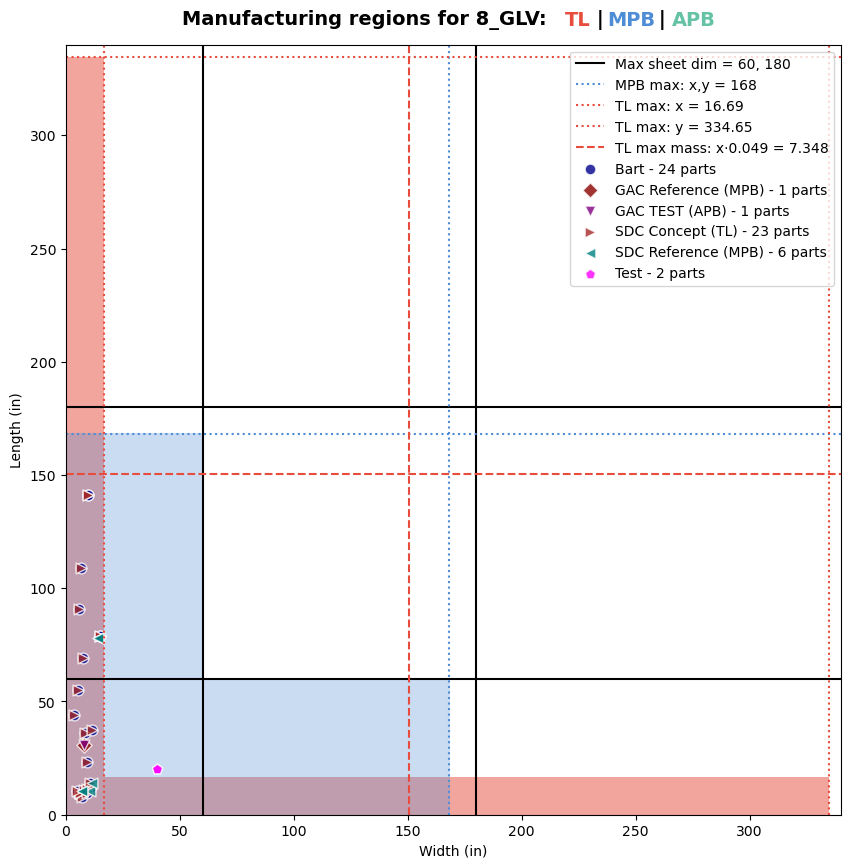

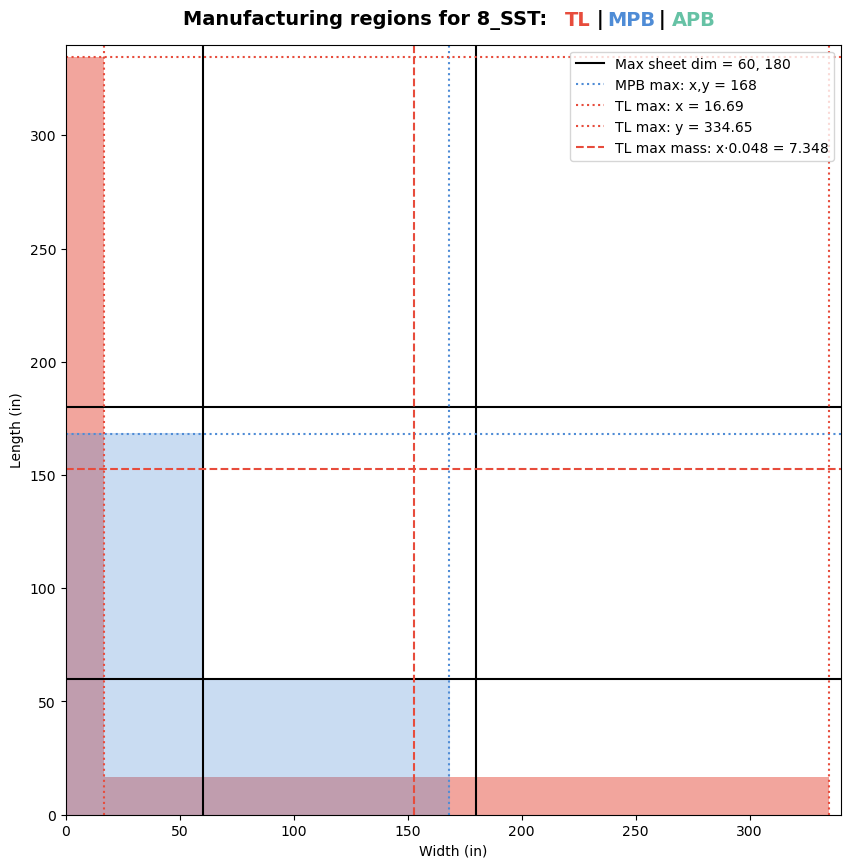

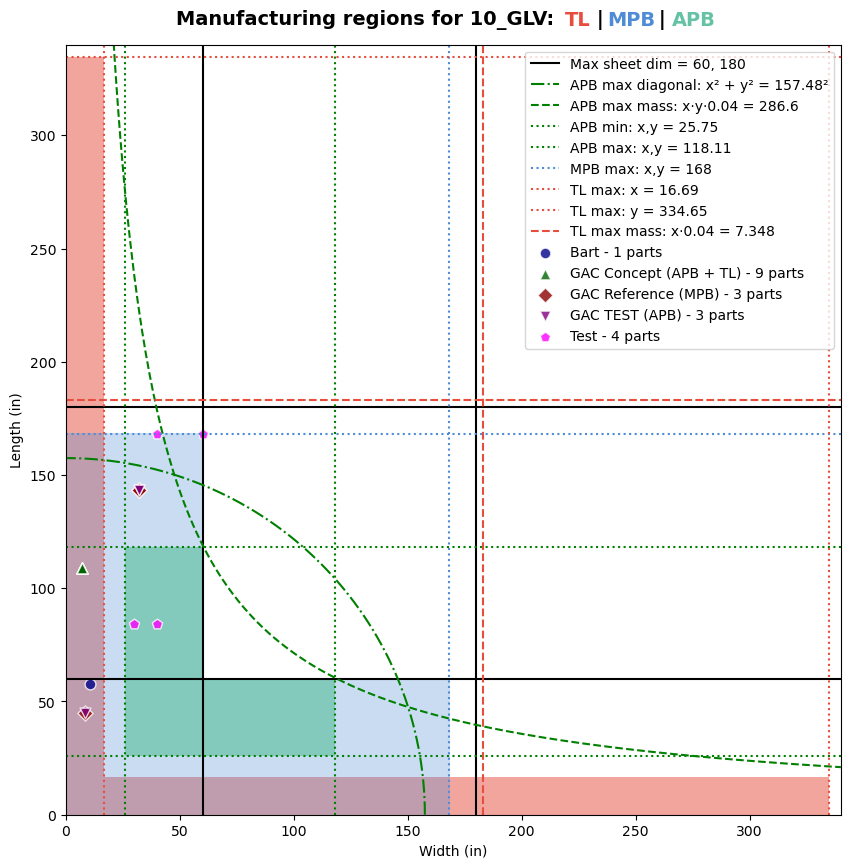

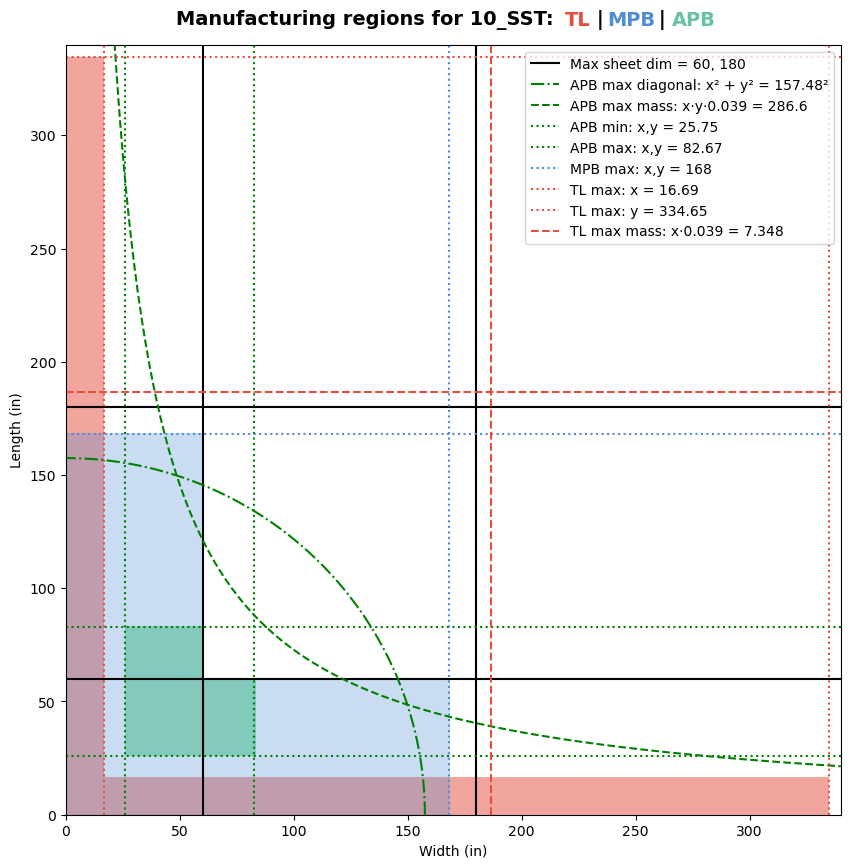

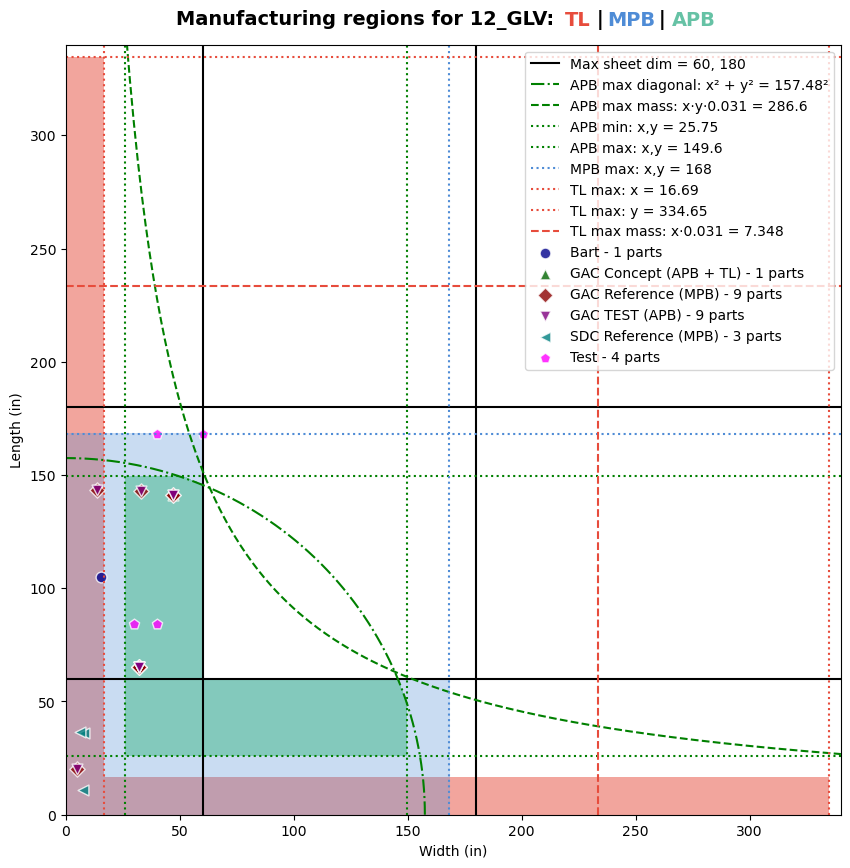

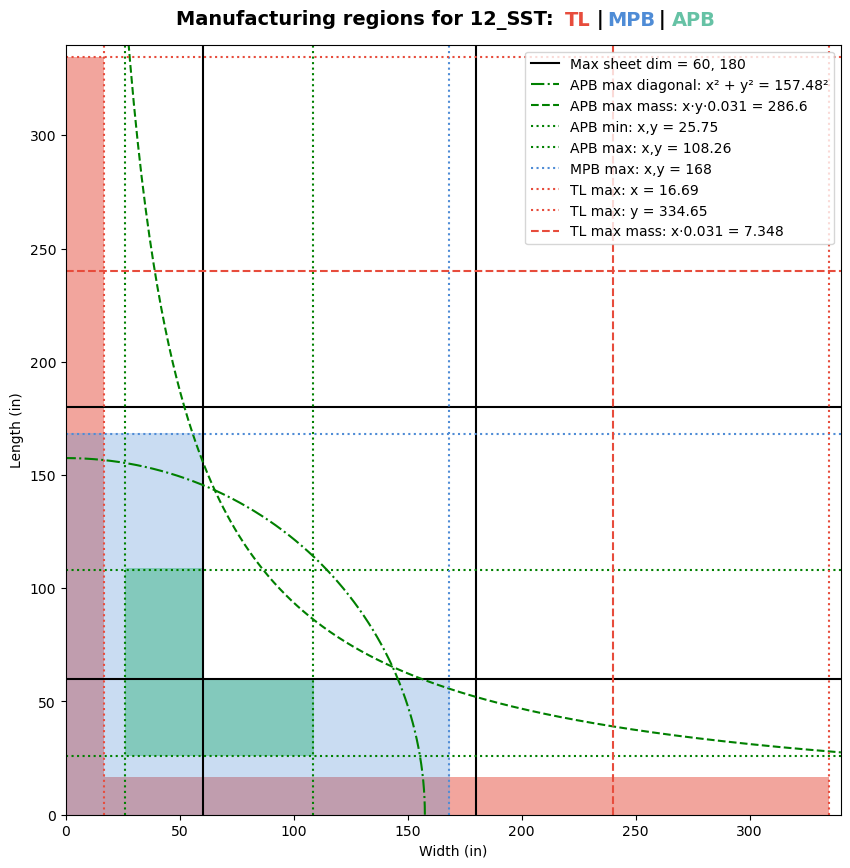

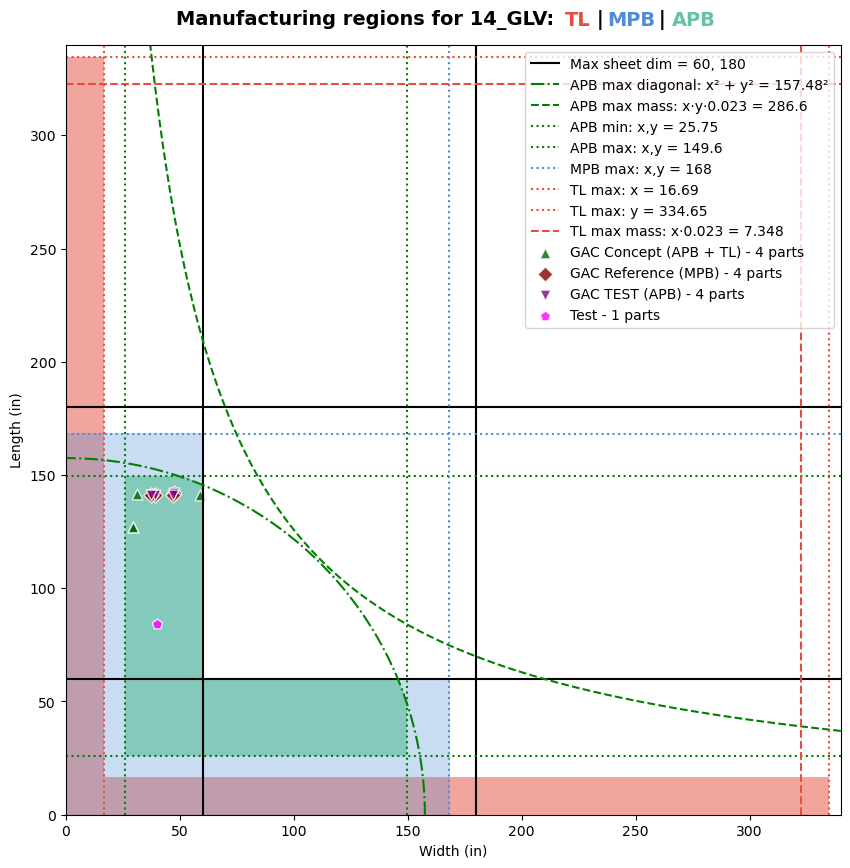

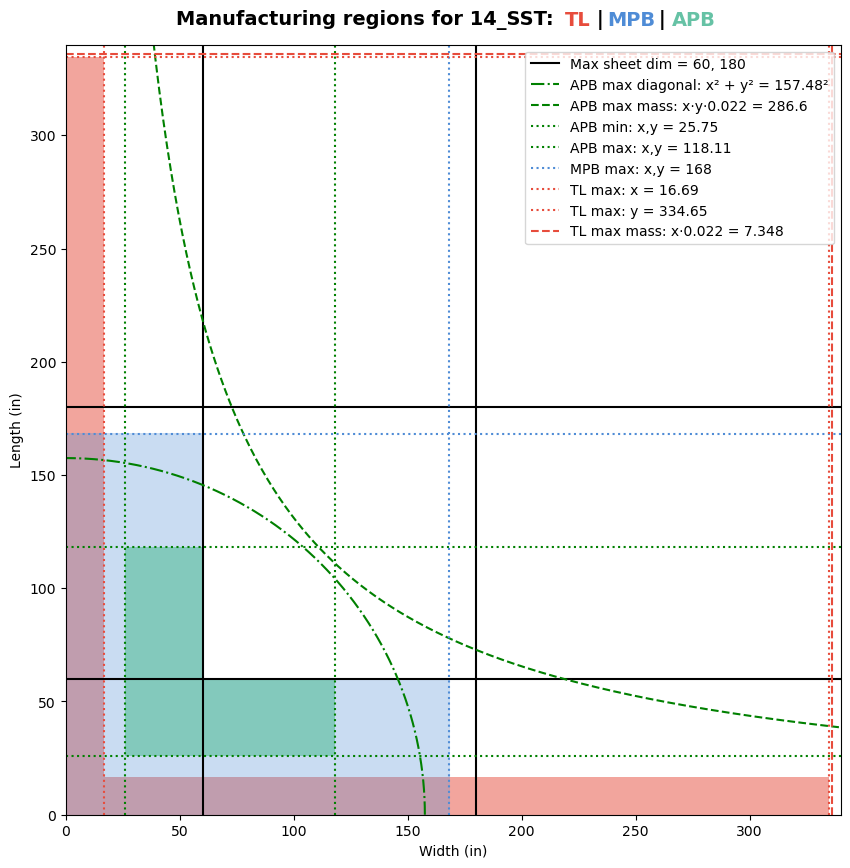

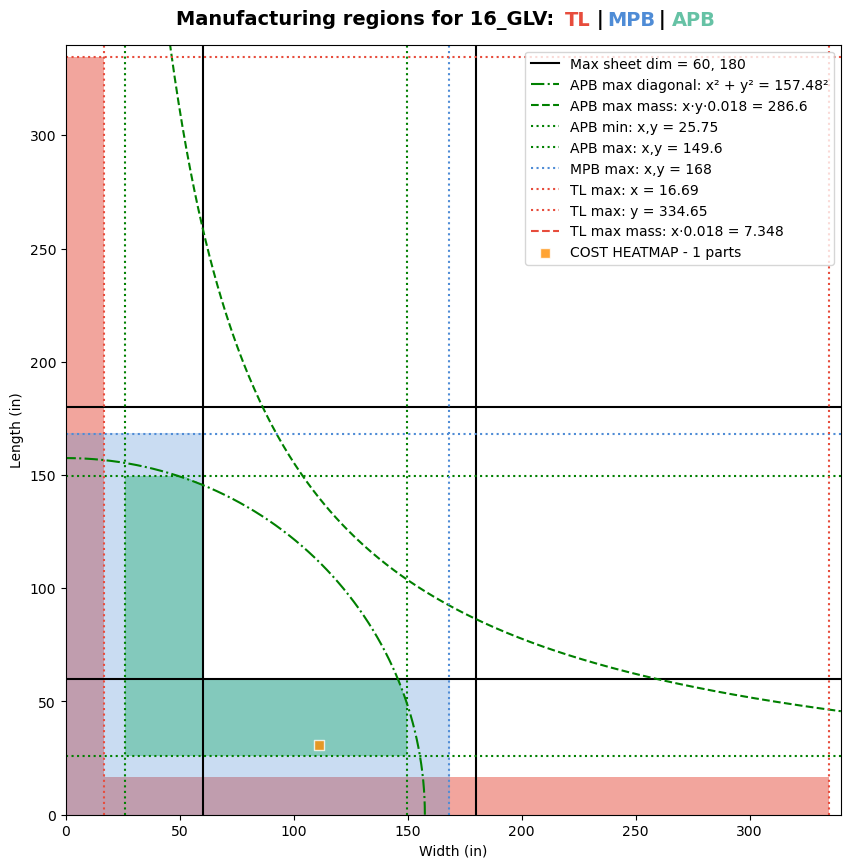

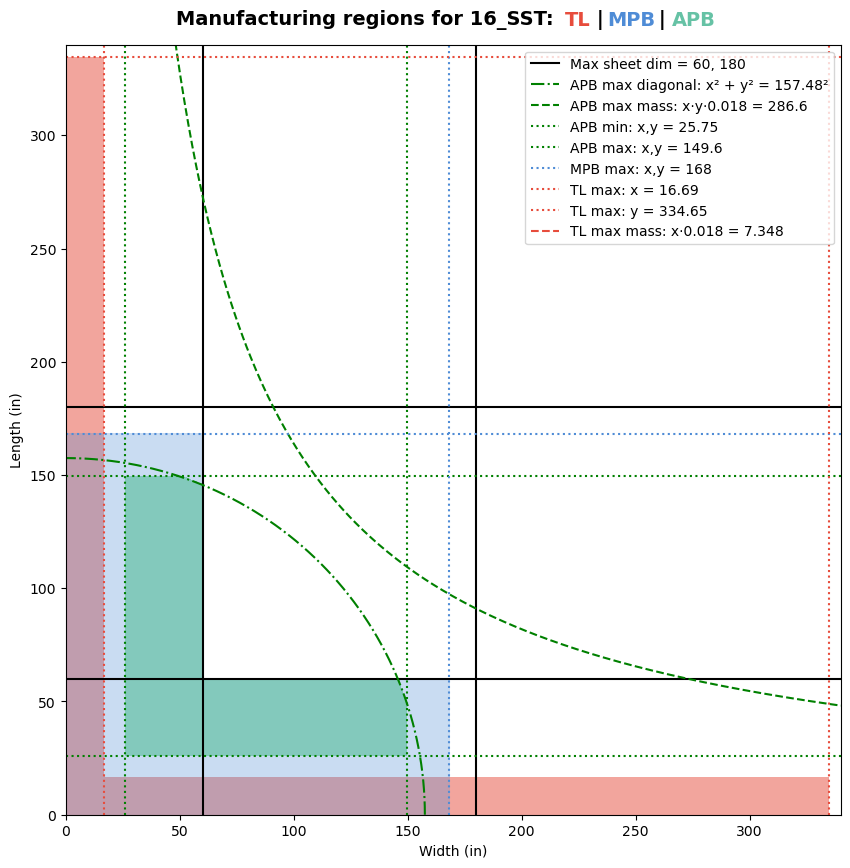

In [448]:
# gauges = df['Gauge'].apply(lambda x: int(x)).unique().tolist()
# materials = df['NCx_Material'].apply(lambda x: str(x)[:3]).unique().tolist() 
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.APB_MPB_TL_plot()
        cap.add_part_sets(part_sets)
        cap.show_plot()

In [ ]:
for app in xw.apps:
    app.quit()

gauges = [16]
materials = ['GLV']
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.generate_cost_heatmaps(path, fastener_spacing=3, bolt_diameter=0.3125)  # Adjust parameters as needed

Generating heatmap for region: APB
Number of feasible points: 287
Workbook processed and closed.


FileNotFoundError: No such file: 'C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx'